<a href="https://colab.research.google.com/github/mpaverill/.crypto/blob/master/altCoin_Recurrent_Nueral_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

btcusd    7560.341307
ethusd     238.520442
ltcusd      92.053194
xrpusd       0.355999
eosusd       5.522764
dtype: float64
btcusd    2336.663805
ethusd     129.307489
ltcusd      58.902394
xrpusd       0.149998
eosusd       3.738023
dtype: float64


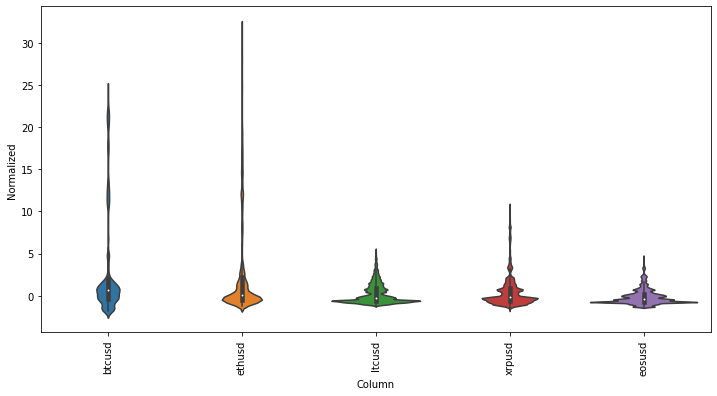

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#Split data 70/20/10 train/val/test
df = pd.read_csv('tensor.csv')
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()
print(train_mean)
print(train_std)

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#Display distribution
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#Class for creating windows of data to train with
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

#Given 1 week of past data predict 1 week ahead
w1 = WindowGenerator(input_width=10080, label_width=1, shift=10080,
                     label_columns=['xrpusd'])  
 
#Given 1 week of past data predict 3 day ahead
w2 = WindowGenerator(input_width=10080, label_width=1, shift=4320,
                     label_columns=['xrpusd'])

#Converts list of inputs into a window of inputs and a window of labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='xrpusd', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['xrpusd'])

wide_window = WindowGenerator(
    input_width=1440, label_width=1440, shift=1,
    label_columns=['xrpusd'])

val_performance = {}
performance = {}

#Training procedure for all models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

lstm_model = tf.keras.models.Sequential([
  # Shape [batch, time, features] => [batch, time, lstm_units]
  tf.keras.layers.LSTM(32, return_sequences=True),
  # Shape => [batch, time, features]
  tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

9495/9495 [==============================] - 636s 67ms/step - loss: 0.0071 - mean_absolute_error: 0.0460


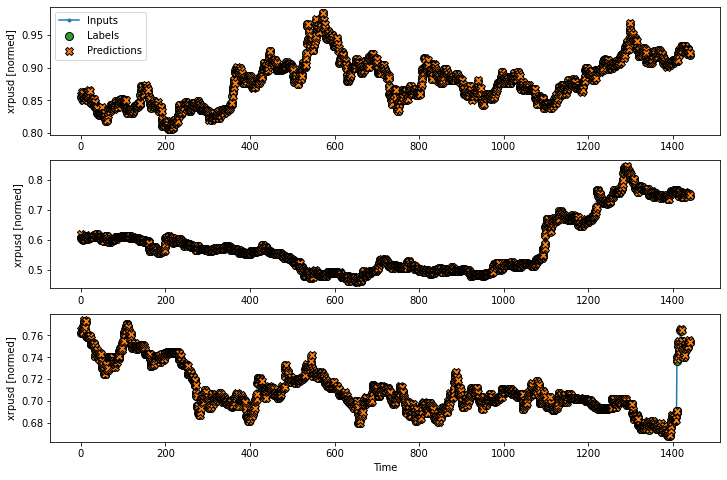

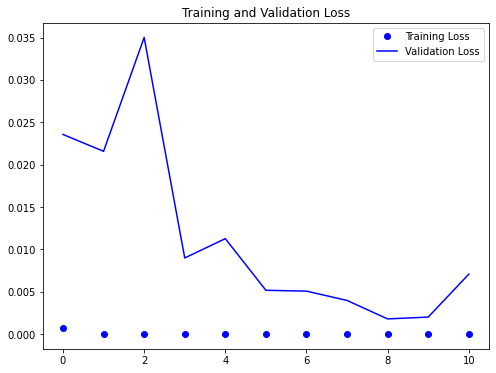

[0.007075722794979811, 0.046009697020053864]
[3.4406936168670654, 1.2395216226577759]
Validation MAE: $ 0.36290064276712763
Test MAE: $ 0.5419245880218221


In [ ]:
wide_window.plot(lstm_model)

#Weights of each column
# plt.bar(x = range(len(train_df.columns)),
#         height=lstm_model.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

#Training/validation loss over epochs
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
epochs1 = range(0, len(loss1), 1)

plt.figure()
plt.plot(epochs1, loss1, 'bo', label='Training Loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

#Scores
print(val_performance['LSTM'])
print(performance['LSTM'])
val_score=((val_performance['LSTM'][1])*train_std[3])+train_mean[3]
test_score=((performance['LSTM'][1])*train_std[3])+train_mean[3]
print('Validation MAE: $' , val_score)
print('Test MAE: $', test_score)

In [ ]:
#Save model
lstm_model.save('MODELS')

INFO:tensorflow:Assets written to: MODELS\assets


INFO:tensorflow:Assets written to: MODELS\assets
